In [1]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap2, add_colorbar, sliceformula_from_tuple, rescale_ticks, heatmap_inputs, dict_lookup, log_dict_lookup
from helpers.predict import predict_from_pifs, formula_input
from helpers.pickletools import save_pickle, load_pickle, pickle_dict
from citrination_client import CitrinationClient
from ternary.helpers import simplex_iterator
import pypif.pif

In [62]:
#refresh modules
try:
    del sys.modules['helpers.plotting']
    del sys.modules['helpers.predict']
except KeyError: pass
try:
    del quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks, heatmap_inputs, dict_lookup, log_dict_lookup
except NameError:
    pass
try:
    del predict_from_pifs, formula_input
except NameError:
    pass
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap2, add_colorbar, sliceformula_from_tuple, rescale_ticks, heatmap_inputs, dict_lookup, log_dict_lookup
from helpers.predict import predict_from_pifs, formula_input

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')
client = client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

## Predicted vs. actual plots

In [103]:
def predvact_from_pifs(srcdir,view_id,cmap=plt.cm.viridis_r,vmin=None,vmax=None):
    pifs = []
    for file in glob.glob(os.path.join(srcdir,'*.json')):
        with open(file,'r') as f:
            fp = pypif.pif.load(f)
            pifs += fp

    predict = ['ASR','logASR']
    exclude = ['formula']
    condition = {'Atmosphere':'dry','Temperature ($^\\circ$C)':437}
    result = predict_from_pifs(view_id,pifs,predict,exclude=exclude,condition=condition)


    result['pred_ASR_fromlog'] = 10**result['pred_logASR']
    result['pred_logASR_fromASR'] = np.log10(result['pred_ASR'])

    fig, axes = plt.subplots(2,2,figsize=(12,10))
    fs = 12
    xaxes = np.array([['ASR','ASR'],['logASR','logASR']])
    xlabels = np.array([['ASR','ASR'],['log(ASR)','log(ASR)']])
    yaxes = np.array([['pred_ASR_fromlog','pred_ASR'],['pred_logASR','pred_logASR_fromASR']])
    ylabels = np.array([['Predicted ASR\n(from log model)','Predicted ASR'],
                        ['Predicted log(ASR)','Predicted log(ASR)\n(from linear model)']])

    if vmin is None:
        vmin = result['logASR'].min()
    if vmax is None:
        vmax = result['logASR'].max()
    
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i,j]
            xax = xaxes[i,j]
            yax = yaxes[i,j]
            xlab = xlabels[i,j]
            ylab = ylabels[i,j]
            ax.scatter(result[xax],result[yax],s=15,c=result['logASR'],cmap=cmap,vmin=vmin,vmax=vmax)

            ax.plot(ax.get_xlim(),ax.get_xlim(),c='gray')
            ax.set_xlabel(xlab,size=fs)
            ax.set_ylabel(ylab,size=fs)

    add_colorbar(fig=fig,ax=axes,vmin=vmin,vmax=vmax, cmap=cmap,
                label='log(ASR)',cbrect=[0.85,0.12,0.02,0.76],labelkwargs={'size':fs,'labelpad':10},
                tickparams={'labelsize':fs-2})

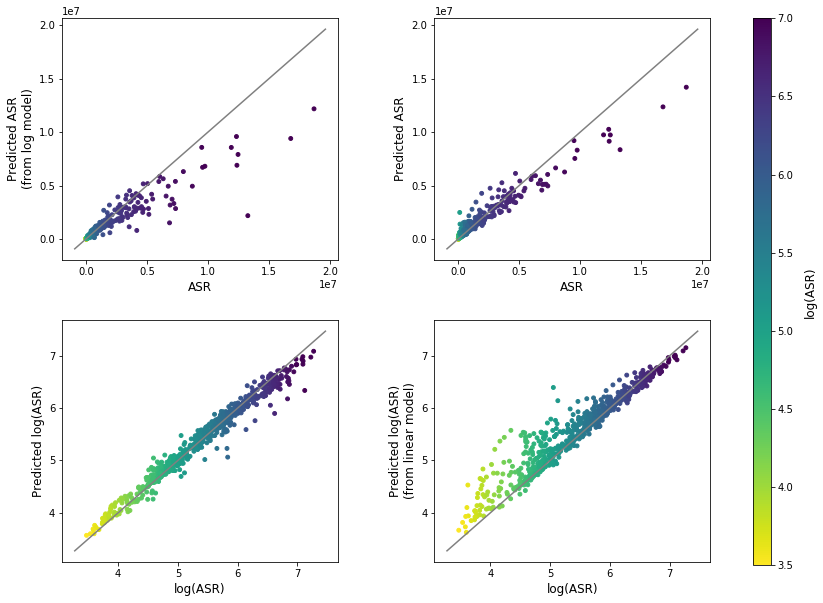

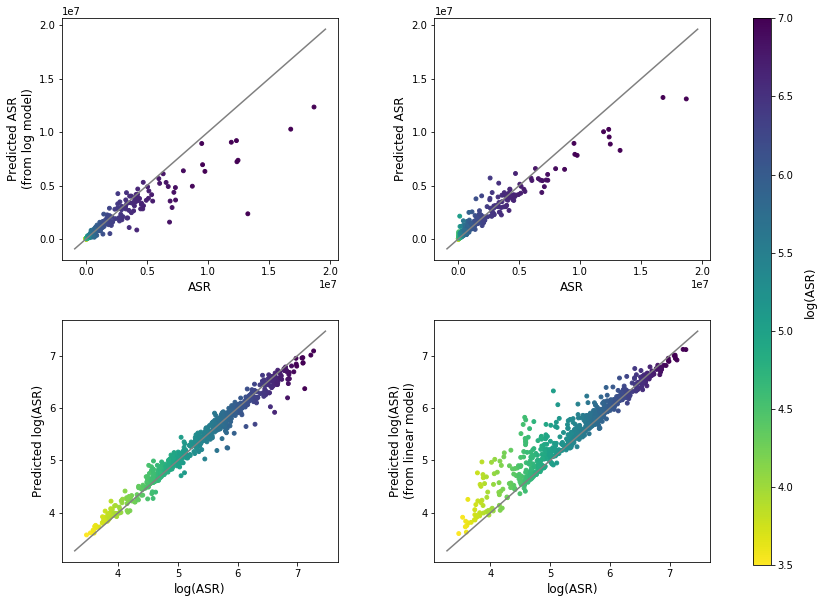

In [104]:
srcdirs = [os.path.join(pifdir,'dryASR_Co(2,3)Fe(3,4)'), os.path.join(pifdir,'dryASR_Co(2,4)Fe(2,4)')]
view_ids = [5046,5047]

for sd, vi in zip(srcdirs,view_ids):
    predvact_from_pifs(sd,vi,vmin=3.5,vmax=7)

# Ternary plots

In [3]:
pickledir = os.path.join(tcodir,'scripts/pickles')


In [4]:
"calculate features/inputs for heatmaps"
calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))
calc_feat_Co24Fe24 = pickle_dict(os.path.join(pickledir,'feat_Co24Fe24'))
calc_feat_Co34Fe23 = pickle_dict(os.path.join(pickledir,'feat_Co34Fe23'))

conditions = {'Atmosphere':'dry','Temperature ($^\circ$C)':473}
#Y slices
calc_inp_Co23Fe34 = heatmap_inputs(cat_ox_lims={'Co':[2,3],'Fe':[3,4]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'], conditions = conditions,
                                   tuple_scale=20,pkl_dict=calc_feat_Co23Fe34)
calc_inp_Co24Fe24 = heatmap_inputs(cat_ox_lims={'Co':[2,4],'Fe':[2,4]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'], conditions = conditions,
                                   tuple_scale=20,pkl_dict=calc_feat_Co24Fe24)
calc_inp_Co34Fe23 = heatmap_inputs(cat_ox_lims={'Co':[3,4],'Fe':[2,3]}, slice_axis='Y', slice_vals=[0,0.05,0.1,0.2],
                                   tern_axes=['Co','Fe','Zr'], conditions = conditions,
                                   tuple_scale=20,pkl_dict=calc_feat_Co34Fe23)

#Zr slices
sliceZr_inp_Co23Fe34 = heatmap_inputs(cat_ox_lims={'Co':[2,3],'Fe':[3,4]}, slice_axis='Zr', slice_vals=[0.1,0.15,0.3,0.45,0.5],
                                      tern_axes=['Co','Fe','Y'], conditions = conditions,
                                      tuple_scale=20,pkl_dict=calc_feat_Co23Fe34)
sliceZr_inp_Co24Fe24 = heatmap_inputs(cat_ox_lims={'Co':[2,4],'Fe':[2,4]}, slice_axis='Zr', slice_vals=[0.1,0.15,0.3,0.45,0.5],
                                      tern_axes=['Co','Fe','Y'], conditions = conditions,
                                      tuple_scale=20,pkl_dict=calc_feat_Co24Fe24)
sliceZr_inp_Co34Fe23 = heatmap_inputs(cat_ox_lims={'Co':[3,4],'Fe':[2,3]}, slice_axis='Zr', slice_vals=[0.1,0.15,0.3,0.45,0.5],
                                      tern_axes=['Co','Fe','Y'], conditions = conditions,
                                      tuple_scale=20,pkl_dict=calc_feat_Co34Fe23)

calc_inp_Co23Fe34.update(sliceZr_inp_Co23Fe34)
calc_inp_Co24Fe24.update(sliceZr_inp_Co24Fe24)
calc_inp_Co34Fe23.update(sliceZr_inp_Co34Fe23)

calc_feat_Co23Fe34.update_file()
calc_feat_Co24Fe24.update_file()
calc_feat_Co34Fe23.update_file()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co24Fe24
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co34Fe23


## ASR

In [28]:
list(calc_inp_Co24Fe24.values())[0:1]

[{'Atmosphere': 'dry',
  'Property A:B_ratio': 0.9,
  'Property A_sum': 0.9,
  'Property B_sum': 1.0,
  'Property Ba_amt': 0.9,
  'Property Co:Fe_ratio': 1000,
  'Property Co_amt': 0.0,
  'Property Fe_amt': 0.0,
  'Property MO_ABE': -440.68616666666674,
  'Property MO_IC_a': 0.8032113561415081,
  'Property MO_IC_avg': 0.7338561415754937,
  'Property MO_IC_b': 0.6714364484660806,
  'Property X_a': 0.89,
  'Property X_avg': 1.1215789473684212,
  'Property X_b': 1.33,
  'Property X_cat_a_oxavg': 0.7715751707110065,
  'Property X_cat_b_oxavg': 7.71604938271605,
  'Property Y_amt': 0.0,
  'Property Zr_amt': 1.0,
  'Property acceptor_magnitude': 0.0,
  'Property alat_oxavg': 4.256782822743016,
  'Property goldschmidt_oxavg': 1.0039582129110884,
  'Property mass_a': 137.327,
  'Property mass_avg': 113.06226315789475,
  'Property mass_b': 91.224,
  'Property n_a_oxavg': 2.0,
  'Property n_b_oxavg': 4.0,
  'Property pred_logsigma_5042': -9.308040193992499,
  'Property pred_logsigma_5044': -9.47

In [7]:
#need to make single prediction before trying to predict list
#seems to be a bug with Citrination API
inp = [{'Atmosphere': 'dry',
  'Property A:B_ratio': 0.9,
  'Property A_sum': 0.9,
  'Property B_sum': 1.0,
  'Property Ba_amt': 0.9,
  'Property Co:Fe_ratio': 1000,
  'Property Co_amt': 0.0,
  'Property Fe_amt': 0.0,
  'Property MO_ABE': -440.68616666666674,
  'Property MO_IC_a': 0.8032113561415081,
  'Property MO_IC_avg': 0.7338561415754937,
  'Property MO_IC_b': 0.6714364484660806,
  'Property X_a': 0.89,
  'Property X_avg': 1.1215789473684212,
  'Property X_b': 1.33,
  'Property X_cat_a_oxavg': 0.7715751707110065,
  'Property X_cat_b_oxavg': 7.71604938271605,
  'Property Y_amt': 0.0,
  'Property Zr_amt': 1.0,
  'Property acceptor_magnitude': 0.0,
  'Property alat_oxavg': 4.256782822743016,
  'Property goldschmidt_oxavg': 1.0039582129110884,
  'Property mass_a': 137.327,
  'Property mass_avg': 113.06226315789475,
  'Property mass_b': 91.224,
  'Property n_a_oxavg': 2.0,
  'Property n_b_oxavg': 4.0,
  'Property pred_logsigma_5042': -9.308040193992499,
  'Property pred_logsigma_5044': -9.470933482878154,
  'Property pred_sigma_5042': 3.031237150119451e-06,
  'Property pred_sigma_5044': 4.235012435510295e-06,
  'Property r_a_oxavg': 1.61,
  'Property r_b_oxavg': 0.72,
  'Property r_b_std_oxavg': 0.0,
  'Property r_crit_oxavg': 0.920775641025641,
  'Property tau_oxavg': 3.5018070336183067,
  'Property tot_cat_charge_oxavg': 5.8,
  'Property trans_met_amt': 0.0,
  'Property uc_vol_free_oxavg': 24.756583030082567,
  'Property uc_vol_oxavg': 77.13375610466801,
  'Temperature ($^\\circ$C)': 473}]
 
results = client.predict(5046,inp)

In [8]:
results[0].get_value('Property logASR').value

5.44003113079775

In [9]:
"predict ASR"
#client can only process <1000 predictions at a time (not sure what the limit is; 600<lim<1000)
npred = 500
"need to predict sigma for input"
res_5042 = []
res_5044 = []
print('Sigma predictions\n-----------------')
for i in range(int(np.ceil(len(calc_inp_Co23Fe34)/npred))):
    print(f'Processing batch {i}')
    start = i*npred
    end = (i+1)*npred
    tres_5042 = client.predict(5042,list(calc_inp_Co23Fe34.values())[start:end])
    tres_5044 = client.predict(5044,list(calc_inp_Co24Fe24.values())[start:end])
    res_5042 += (tres_5042)
    res_5044 += (tres_5044)

sigma_pred_5042 = [r.get_value('Property sigma_e').value for r in res_5042]
sigma_pred_5044 = [r.get_value('Property sigma_e').value for r in res_5044]

logsigma_pred_5042 = [r.get_value('Property log_sigma_e').value for r in res_5042]
logsigma_pred_5044 = [r.get_value('Property log_sigma_e').value for r in res_5044]

"add sigma predictions to inputs"
for key, s5042,s5044,ls5042,ls5044 in zip(calc_inp_Co23Fe34.keys(),sigma_pred_5042,sigma_pred_5044
                                          ,logsigma_pred_5042,logsigma_pred_5044):
    names = ['Property pred_sigma_5042',
             'Property pred_sigma_5044',
             'Property pred_logsigma_5042',
             'Property pred_logsigma_5044']
    vals = [s5042,s5044,ls5042,ls5044]
    upd = dict(zip(names,vals))
    calc_inp_Co23Fe34[key].update(upd)
    calc_inp_Co24Fe24[key].update(upd)
    
"all inputs ready - predict ASR"    
res_5046 = []
res_5047 = []
print('ASR predictions\n-----------------')
for i in range(int(np.ceil(len(calc_inp_Co23Fe34)/npred))):
    print(f'Processing batch {i}')
    start = i*npred
    end = (i+1)*npred
    tres_5046 = client.predict(5046,list(calc_inp_Co23Fe34.values())[start:end])
    tres_5047 = client.predict(5047,list(calc_inp_Co24Fe24.values())[start:end])
    res_5046 += (tres_5046)
    res_5047 += (tres_5047)

asr_pred_5046 = [r.get_value('Property ASR').value for r in res_5046]
asr_pred_5047 = [r.get_value('Property ASR').value for r in res_5047]

logasr_pred_5046 = [r.get_value('Property logASR').value for r in res_5046]
logasr_pred_5047 = [r.get_value('Property logASR').value for r in res_5047]

#dicts for slicetup_lookup
asr_5046_dict = dict(zip(calc_inp_Co23Fe34.keys(),asr_pred_5046))
asr_5047_dict = dict(zip(calc_inp_Co24Fe24.keys(),asr_pred_5047))

logasr_5046_dict = dict(zip(calc_inp_Co23Fe34.keys(),logasr_pred_5046))
logasr_5047_dict = dict(zip(calc_inp_Co24Fe24.keys(),logasr_pred_5047))

0
1
2
3
4


In [43]:
def pred_asr_slice_plots(slice_axis,tern_axes,slice_vals,zdict,zfunc,title,logscale=False,
                         vmin=None,vmax=None,cmap = plt.cm.viridis_r):
    fig, axes = plt.subplots(1,3,figsize=(20,6))
    if vmin is None:
        if zfunc == log_dict_lookup:
            vmin = np.log10(min(zdict.values()))
        else:
            vmin = min(zdict.values())
    if vmax is None:
        if zfunc == log_dict_lookup:
            vmax= np.log10(max(zdict.values()))
        else:
            vmax = max(zdict.values())
            
    print(vmin,vmax)

    for i,slice_val in enumerate(slice_vals):
        ax = axes[i]
        tax, vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, slice_axis=slice_axis,
                                         tern_axes=tern_axes, vmin=vmin, vmax=vmax, ax=ax, Ba=0.9,
                                         zfunc_kwargs={'kdict':zdict}, cmap = cmap,
                                         labelsize=15, multiple=(1-slice_val)/5, add_labeloffset=0.05,
                                         tick_kwargs={'tick_formats': '%.2g', 'offset': 0.03,'fontsize':11} )


        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.15,y=0.9,size=15,bbox=props)

    if logscale==True:
        cblabel = 'Predicted log(ASR)'
        cbtickfmt = '%.1f'
    else:
        cblabel = 'Predicted ASR'
        cbtickfmt = '%.0e'
    add_colorbar(vmin=vmin,vmax=vmax,label=cblabel,labelkwargs={'size':16,'labelpad':10}, cmap=cmap,
                 tickparams={'labelsize':12}, tickformat=cbtickfmt,cbrect=[0.9,0.18,0.02,0.53],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
    fig.suptitle(title,size='18')
    fig.subplots_adjust(top=0.7)
    
    return fig, axes

"larger font size for smaller figures"
# def pred_asr_slice_plots(slice_axis,tern_axes,slice_vals,zdict,zfunc,title,logscale=False,
#                          vmin=None,vmax=None,cmap = plt.cm.viridis_r):
#     fig, axes = plt.subplots(1,3,figsize=(20,6))
#     if vmin is None:
#         if zfunc == log_dict_lookup:
#             vmin = np.log10(min(zdict.values()))
#         else:
#             vmin = min(zdict.values())
#     if vmax is None:
#         if zfunc == log_dict_lookup:
#             vmax= np.log10(max(zdict.values()))
#         else:
#             vmax = max(zdict.values())
            
#     print(vmin,vmax)

#     for i,slice_val in enumerate(slice_vals):
#         ax = axes[i]
#         tax, vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, slice_axis=slice_axis,
#                                          tern_axes=tern_axes, vmin=vmin, vmax=vmax, ax=ax, Ba=0.9,
#                                          zfunc_kwargs={'kdict':zdict}, cmap = cmap,
#                                          labelsize=25, multiple=(1-slice_val)/4, add_labeloffset=0.1,
#                                          tick_kwargs={'tick_formats': '%.2g', 'offset': 0.05,'fontsize':18} )


#         props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#         ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.12,y=0.9,size=22,bbox=props)

#     if logscale==True:
#         cblabel = 'Predicted log(ASR)'
#         cbtickfmt = '%.1f'
#     else:
#         cblabel = 'Predicted ASR'
#         cbtickfmt = '%.0e'
#     add_colorbar(vmin=vmin,vmax=vmax,label=cblabel,labelkwargs={'size':22,'labelpad':10}, cmap=cmap,
#                  tickparams={'labelsize':18}, tickformat=cbtickfmt,cbrect=[0.9,0.18,0.02,0.53],
#                 subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
#     fig.suptitle(title,size='18')
#     fig.subplots_adjust(top=0.7)
    
#     return fig, axes

### Y slices (ASR)

In [18]:
#set consistent vmin and vmax for all plots
all_vmin = 3.5
all_vmax = 7

3.5 7


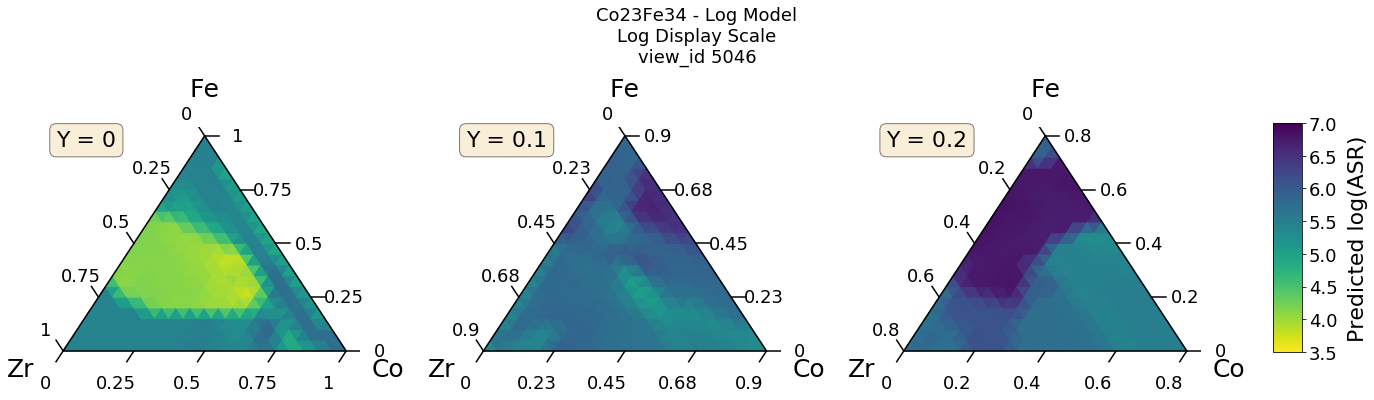

In [45]:
fig, axes = pred_asr_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=logasr_5046_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Log Model\nLog Display Scale\nview_id 5046',
                                   logscale=True)
#axes[2].scatter
plt.savefig(os.path.join(plotdir,'pred_logasr5046_sliceY_BigText.png'),dpi=500)

3.5 7


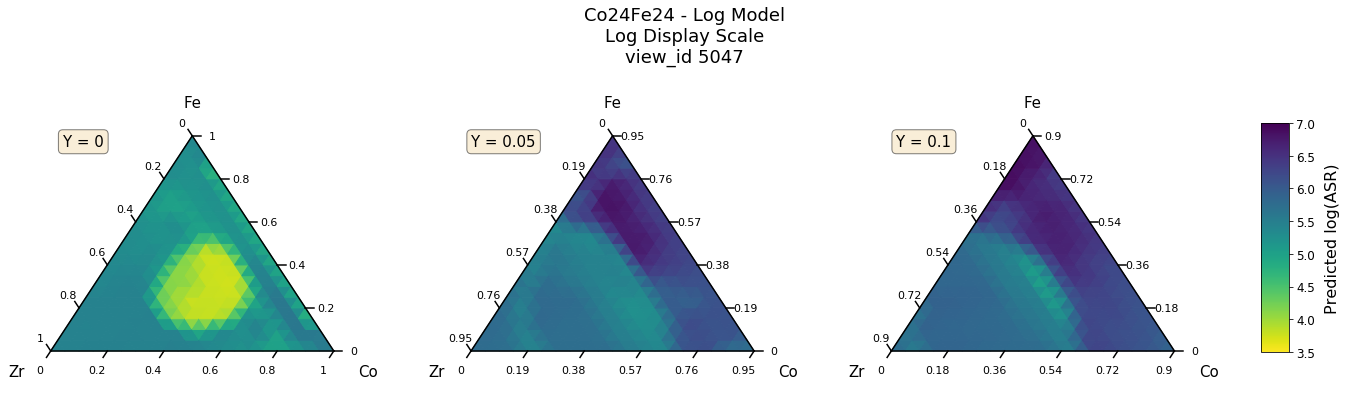

In [41]:
fig, axes = pred_asr_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.05,0.1],
                                   zdict=logasr_5047_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Log Model\nLog Display Scale\nview_id 5047',
                                   logscale=True)
#plt.savefig(os.path.join(plotdir,'pred_logasr5047_sliceY.png'),dpi=500)

3 7.5


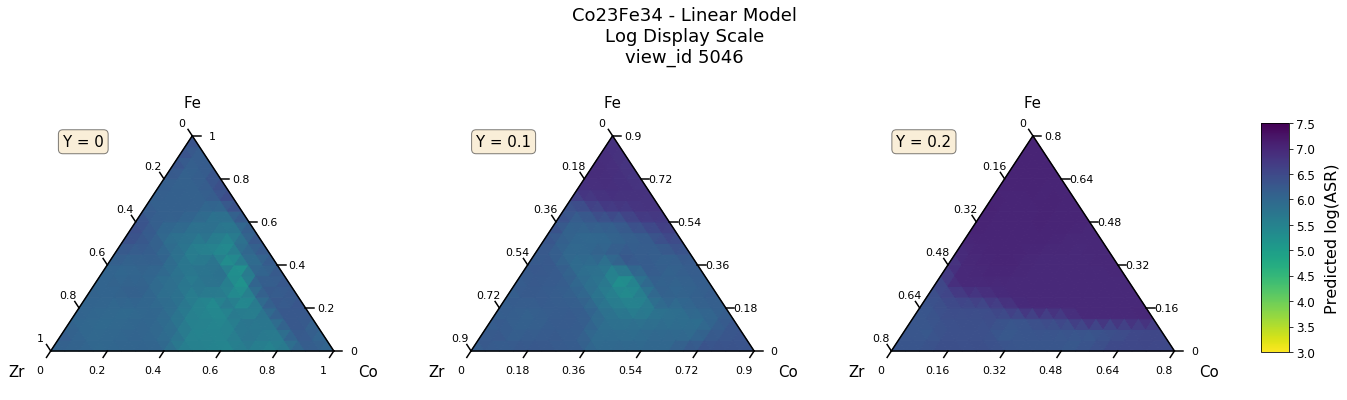

In [83]:
fig, axes = pred_asr_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=asr_5046_dict,zfunc=log_dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Linear Model\nLog Display Scale\nview_id 5046',
                                   logscale=True)

3 7.5


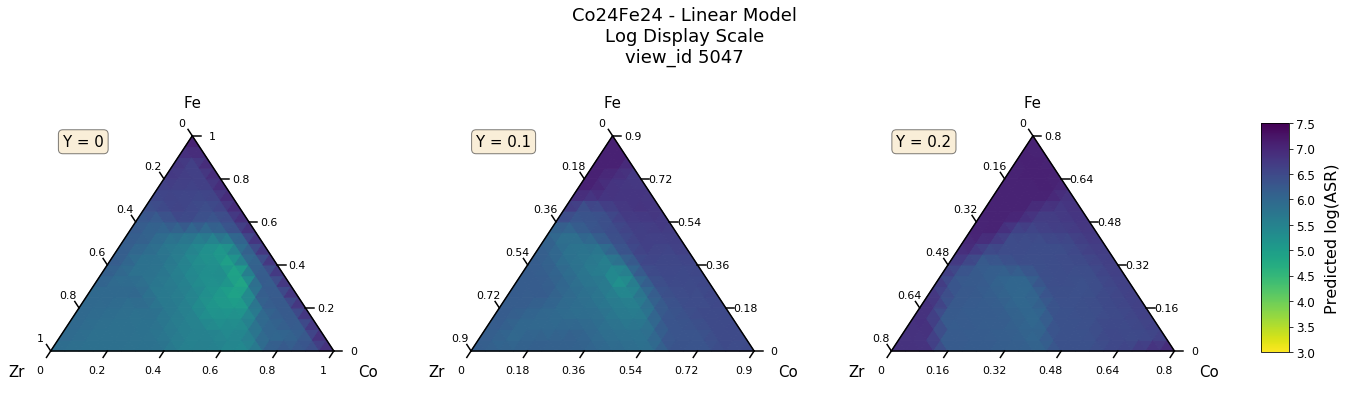

In [84]:
fig, axes = pred_asr_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=asr_5047_dict,zfunc=log_dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Linear Model\nLog Display Scale\nview_id 5047',
                                   logscale=True)

### Zr slices (ASR)

3.5 7


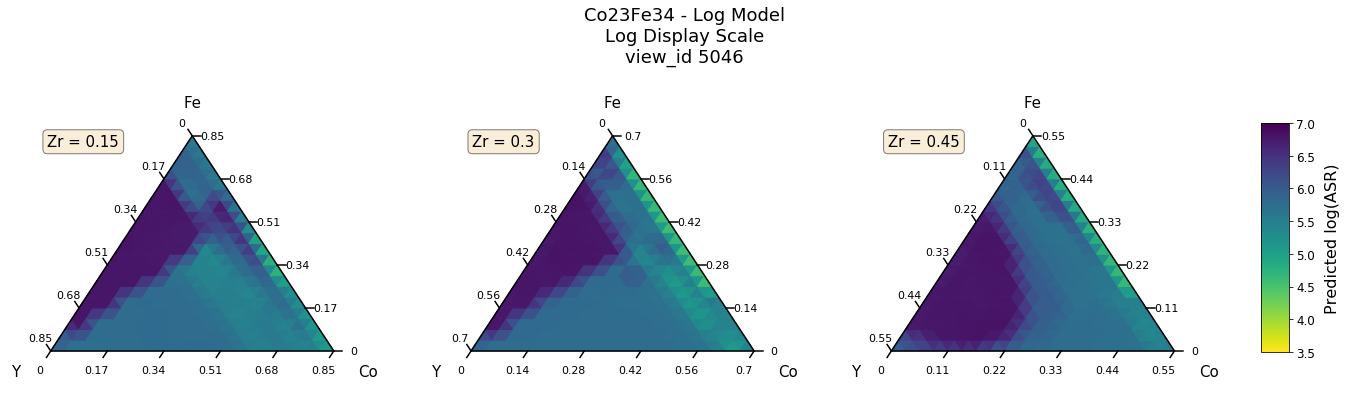

In [96]:
fig, axes = pred_asr_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=logasr_5046_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Log Model\nLog Display Scale\nview_id 5046',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logasr5046_sliceZr.png'),dpi=500)

3.5 7


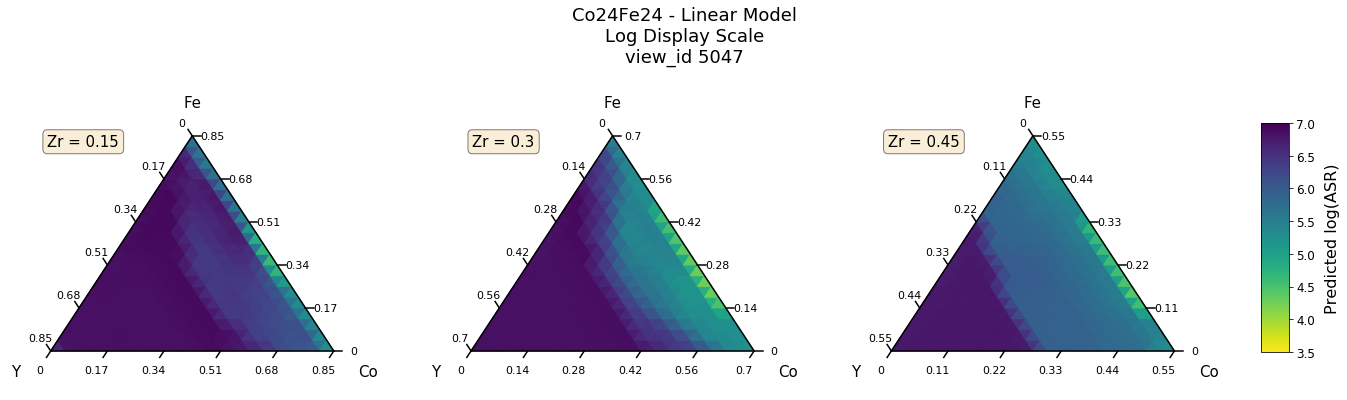

In [97]:
fig, axes = pred_asr_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=logasr_5047_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Linear Model\nLog Display Scale\nview_id 5047',
                                   logscale=True)
plt.savefig(os.path.join(plotdir,'pred_logasr5047_sliceZr.png'),dpi=500)

In [88]:
min(logasr_pred_5046),max(logasr_pred_5046)

(3.8601456356077635, 6.8771327891921965)

## E_a

In [6]:
import copy

In [7]:
"make dicts for wet inputs"
"must be separate dict since key is just formula"
wet_inp_Co23Fe34 = copy.deepcopy(calc_inp_Co23Fe34)
for k,v in wet_inp_Co23Fe34.items():
    wet_inp_Co23Fe34[k]['Atmosphere'] = 'wet'
    
wet_inp_Co24Fe24 = copy.deepcopy(calc_inp_Co24Fe24)
for k,v in wet_inp_Co24Fe24.items():
    wet_inp_Co24Fe24[k]['Atmosphere'] = 'wet'

In [8]:
"predict E_a"
#client can only process <1000 predictions at a time (not sure what the limit is; 600<lim<1000)
npred = 500
# "need to predict sigma for input"
# res_5042 = []
# res_5044 = []
# for i in range(int(np.ceil(len(calc_inp_Co23Fe34)/npred))):
#     start = i*npred
#     end = (i+1)*npred
#     tres_5042 = client.predict(5042,list(calc_inp_Co23Fe34.values())[start:end])
#     tres_5044 = client.predict(5044,list(calc_inp_Co24Fe24.values())[start:end])
#     res_5042 += (tres_5042)
#     res_5044 += (tres_5044)

# sigma_pred_5042 = [r.get_value('Property sigma_e').value for r in res_5042]
# sigma_pred_5044 = [r.get_value('Property sigma_e').value for r in res_5044]

# logsigma_pred_5042 = [r.get_value('Property log_sigma_e').value for r in res_5042]
# logsigma_pred_5044 = [r.get_value('Property log_sigma_e').value for r in res_5044]

# "add sigma predictions to inputs"
# for key, s5042,s5044,ls5042,ls5044 in zip(calc_inp_Co23Fe34.keys(),sigma_pred_5042,sigma_pred_5044
#                                           ,logsigma_pred_5042,logsigma_pred_5044):
#     names = ['Property pred_sigma_5042',
#              'Property pred_sigma_5044',
#              'Property pred_logsigma_5042',
#              'Property pred_logsigma_5044']
#     vals = [s5042,s5044,ls5042,ls5044]
#     upd = dict(zip(names,vals))
#     calc_inp_Co23Fe34[key].update(upd)
#     calc_inp_Co24Fe24[key].update(upd)

"all inputs ready - predict E_a"    
"predict wet and dry and put in separate dicts"
dry_res_5227 = []
dry_res_5228 = []
wet_res_5227 = []
wet_res_5228 = []

for i in range(int(np.ceil(len(calc_inp_Co23Fe34)/npred))):
    start = i*npred
    end = (i+1)*npred
    #dry
    tdres_5227 = client.predict(5227,list(calc_inp_Co23Fe34.values())[start:end])
    tdres_5228 = client.predict(5228,list(calc_inp_Co24Fe24.values())[start:end])
    dry_res_5227 += (tdres_5227)
    dry_res_5228 += (tdres_5228)
    #wet
    twres_5227 = client.predict(5227,list(wet_inp_Co23Fe34.values())[start:end])
    twres_5228 = client.predict(5228,list(wet_inp_Co24Fe24.values())[start:end])
    wet_res_5227 += (twres_5227)
    wet_res_5228 += (twres_5228)
    
dryEa_pred_5227 = [r.get_value('Property $E_a$').value for r in dry_res_5227]
dryEa_pred_5228 = [r.get_value('Property $E_a$').value for r in dry_res_5228]
wetEa_pred_5227 = [r.get_value('Property $E_a$').value for r in wet_res_5227]
wetEa_pred_5228 = [r.get_value('Property $E_a$').value for r in wet_res_5228]

#dicts for slicetup_lookup
dryEa_5227_dict = dict(zip(calc_inp_Co23Fe34.keys(),dryEa_pred_5227))
dryEa_5228_dict = dict(zip(calc_inp_Co24Fe24.keys(),dryEa_pred_5228))
wetEa_5227_dict = dict(zip(wet_inp_Co23Fe34.keys(),wetEa_pred_5227))
wetEa_5228_dict = dict(zip(wet_inp_Co24Fe24.keys(),wetEa_pred_5228))
print('done')

done


(array([139., 344., 226., 862., 273.,  86.,  82.,  32.,  24.,  11.]),
 array([0.21267381, 0.31500996, 0.41734612, 0.51968227, 0.62201842,
        0.72435457, 0.82669072, 0.92902688, 1.03136303, 1.13369918,
        1.23603533]),
 <a list of 10 Patch objects>)

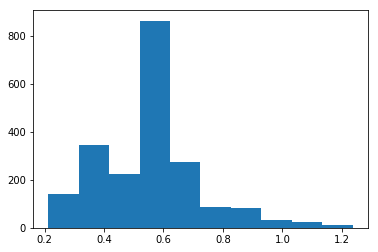

In [137]:
plt.hist(dryEa_pred_5227)

In [23]:
def pred_Ea_slice_plots(slice_axis,tern_axes,slice_vals,zdict,zfunc,title,
                         vmin=None,vmax=None,cmap = plt.cm.viridis_r):
    fig, axes = plt.subplots(1,3,figsize=(20,6))
    if vmin is None:
        if zfunc == log_dict_lookup:
            vmin = np.log10(min(zdict.values()))
        else:
            vmin = min(zdict.values())
    if vmax is None:
        if zfunc == log_dict_lookup:
            vmax= np.log10(max(zdict.values()))
        else:
            vmax = max(zdict.values())
            
    print(vmin,vmax)

    for i,slice_val in enumerate(slice_vals):
        ax = axes[i]
        tax, vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, slice_axis=slice_axis,
                                         tern_axes=tern_axes, vmin=vmin, vmax=vmax, ax=ax, Ba=0.9,
                                         zfunc_kwargs={'kdict':zdict}, cmap = cmap,
                                         labelsize=15, multiple=(1-slice_val)/5, add_labeloffset=0.05,
                                         tick_kwargs={'tick_formats': '%.2g', 'offset': 0.03,'fontsize':11} )


        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.15,y=0.9,size=15,bbox=props)

    add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $E_a$ (eV)',labelkwargs={'size':16,'labelpad':10}, cmap=cmap,
                 tickparams={'labelsize':12}, tickformat='%.1f',cbrect=[0.9,0.18,0.02,0.53],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
    fig.suptitle(title,size='18')
    fig.subplots_adjust(top=0.7)
    
    return fig, axes

In [24]:
#set consistent vmin and vmax for all plots
all_vmin = 0.2
all_vmax = 1

### Y slices ($E_a$)

0.2 1


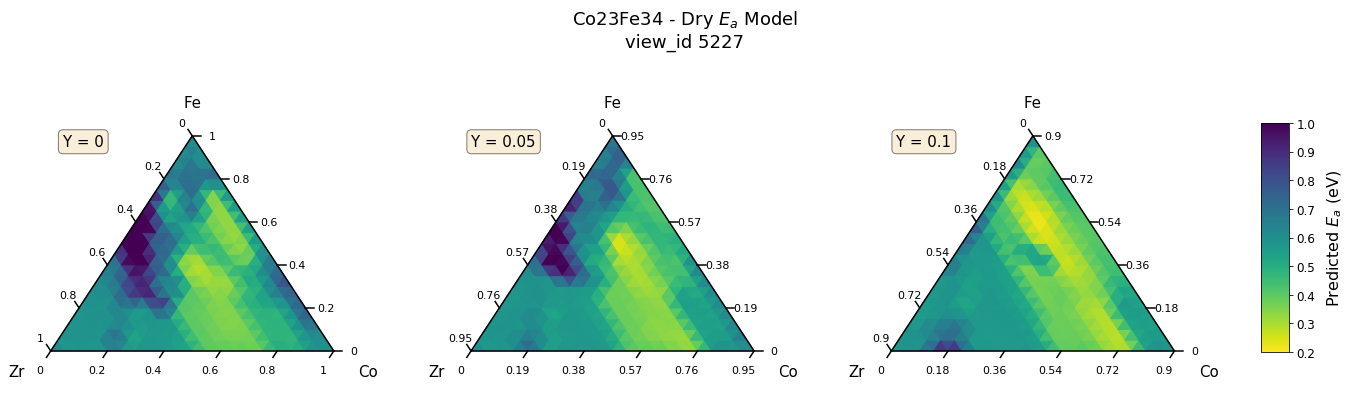

In [25]:
fig, axes = pred_Ea_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.05,0.1],
                                   zdict=dryEa_5227_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Dry $E_a$ Model\nview_id 5227')
plt.savefig(os.path.join(plotdir,'pred_dry_Ea5227_sliceY_low.png'),dpi=400)

0.2 1


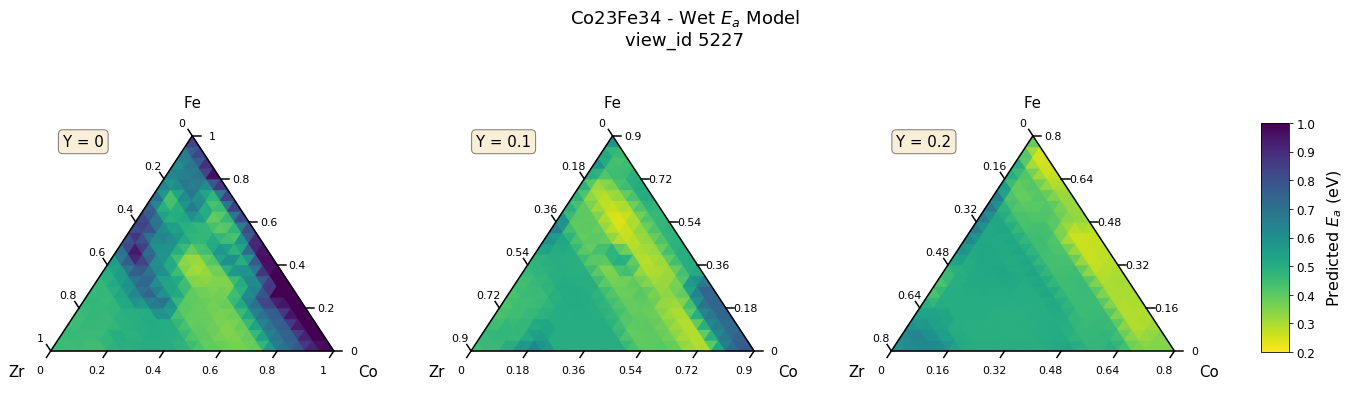

In [152]:
fig, axes = pred_Ea_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=wetEa_5227_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Wet $E_a$ Model\nview_id 5227')
plt.savefig(os.path.join(plotdir,'pred_wet_Ea5227_sliceY.png'),dpi=400)

0.2 1


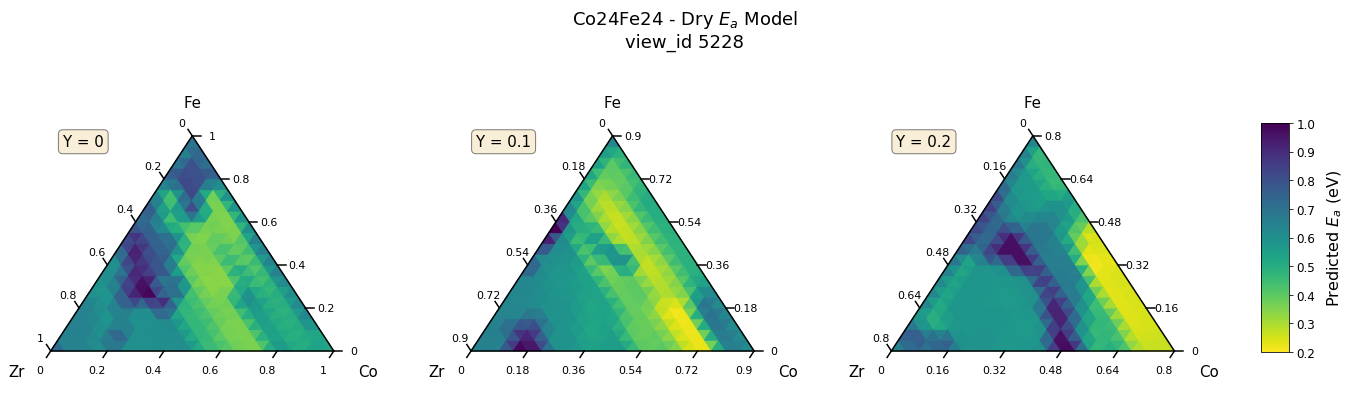

In [153]:
fig, axes = pred_Ea_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=dryEa_5228_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Dry $E_a$ Model\nview_id 5228')
plt.savefig(os.path.join(plotdir,'pred_dry_Ea5228_sliceY.png'),dpi=400)

0.2 1


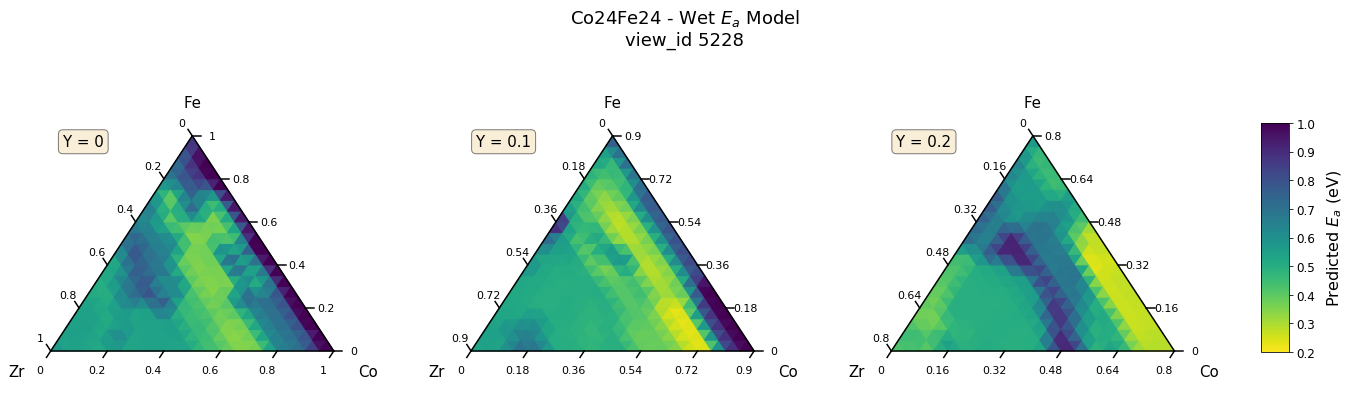

In [154]:
fig, axes = pred_Ea_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.1,0.2],
                                   zdict=wetEa_5228_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Wet $E_a$ Model\nview_id 5228')
plt.savefig(os.path.join(plotdir,'pred_wet_Ea5228_sliceY.png'),dpi=400)

### Zr slices ($E_a$)

0.2 1


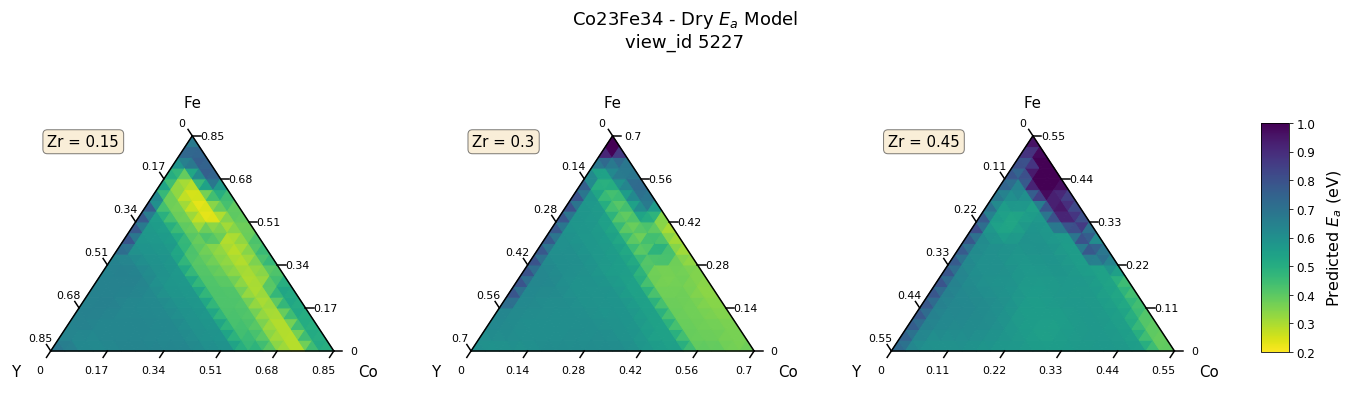

In [155]:
fig, axes = pred_Ea_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=dryEa_5227_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Dry $E_a$ Model\nview_id 5227')
plt.savefig(os.path.join(plotdir,'pred_dry_Ea5227_sliceZr.png'),dpi=400)

0.2 1


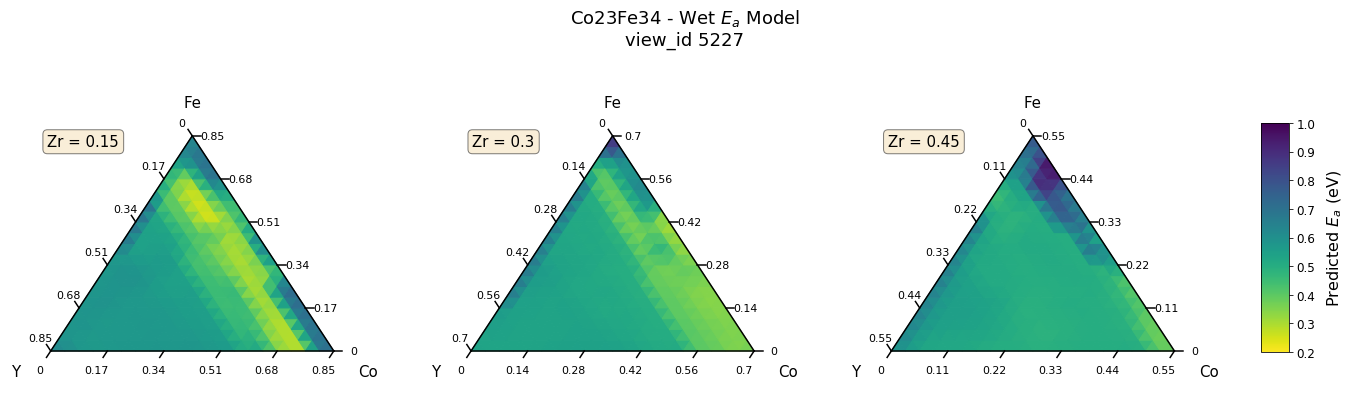

In [156]:
fig, axes = pred_Ea_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=wetEa_5227_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co23Fe34 - Wet $E_a$ Model\nview_id 5227')
plt.savefig(os.path.join(plotdir,'pred_wet_Ea5227_sliceZr.png'),dpi=400)

0.2 1


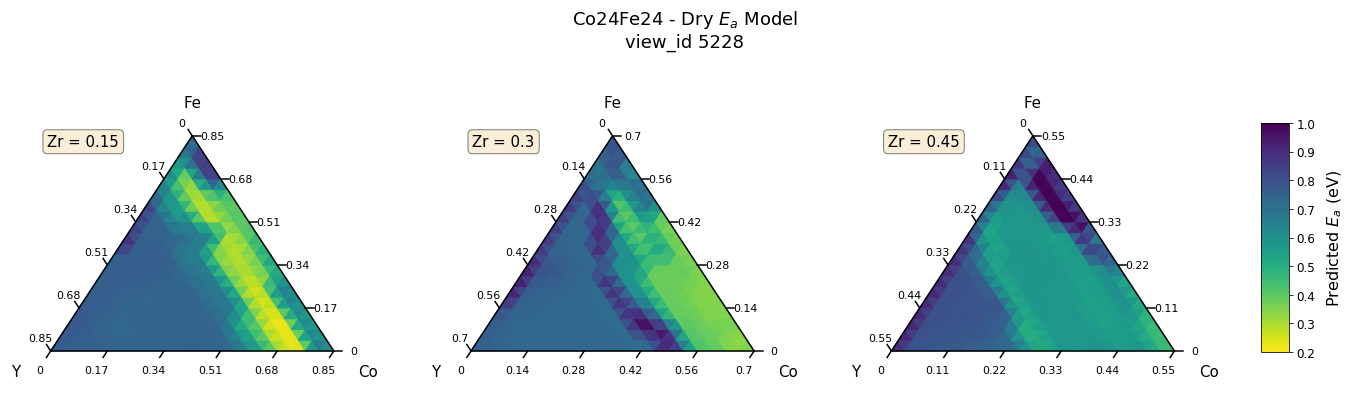

In [157]:
fig, axes = pred_Ea_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=dryEa_5228_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Dry $E_a$ Model\nview_id 5228')
plt.savefig(os.path.join(plotdir,'pred_dry_Ea5228_sliceZr.png'),dpi=400)

0.2 1


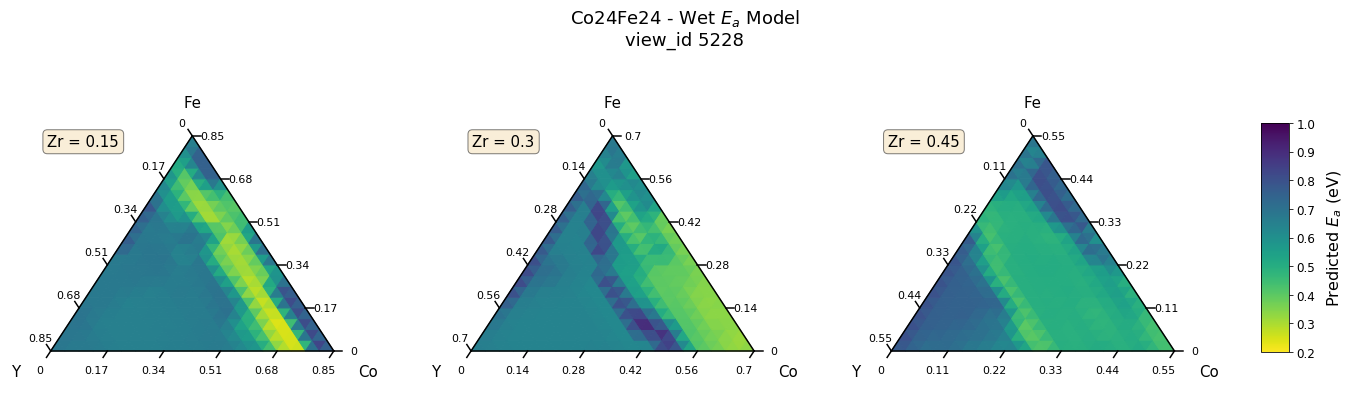

In [158]:
fig, axes = pred_Ea_slice_plots(slice_axis='Zr',tern_axes=['Co','Fe','Y'],slice_vals=[0.15,0.3,0.45],
                                   zdict=wetEa_5228_dict,zfunc=dict_lookup, vmin=all_vmin, vmax=all_vmax,
                                   title='Co24Fe24 - Wet $E_a$ Model\nview_id 5228')
plt.savefig(os.path.join(plotdir,'pred_wet_Ea5228_sliceZr.png'),dpi=400)

# Overlay of all 3 models ($\sigma$, log(ASR), $E_a$)

Use dicts:

logsigma_5042_dict

logasr_5046_dict

dryEa_5227_dict

In [9]:
"make sigma dict"
logsigma_5042_dict = dict(zip(calc_inp_Co23Fe34.keys(),logsigma_pred_5042))

Text(0.5,1,'E_a')

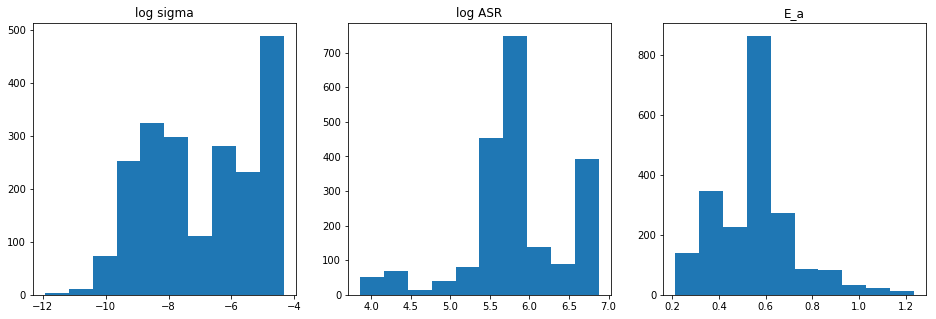

In [167]:
fig, axes = plt.subplots(1,3,figsize=(16,5))

axes[0].hist(logsigma_5042_dict.values())
axes[0].set_title('log sigma')

axes[1].hist(logasr_5046_dict.values())
axes[1].set_title('log ASR')

axes[2].hist(dryEa_5227_dict.values())
axes[2].set_title('E_a')

In [10]:
# def normscale(x,xmin,xmax,normrange=(-1,1)):
#     if x > xmax:
#         x = xmax
#     if x < xmin:
#         x = xmin
#     xscale = xmax-xmin
#     normscale = normrange[1] - normrange[0]
#     return (x-xmin)*normscale/xscale + normrange[0]

def normscale(xvalues,xmin=None,xmax=None,normrange=(-1,1)):
    if type(xvalues)==list:
        xvalues = np.array(xvalues)
    if xmin is None:
        xmin = min(xvalues)
    if xmax is None:
        xmax = max(xvalues)
    xscale = xmax-xmin
    #bring in values beyond limits
    xvalues[xvalues > xmax] = xmax
    xvalues[xvalues < xmin] = xmin
    nscale = normrange[1] - normrange[0]
    return (xvalues-xmin)*nscale/xscale + normrange[0]

(array([ 46., 164., 182., 343., 225.,  61., 255., 184., 207., 412.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

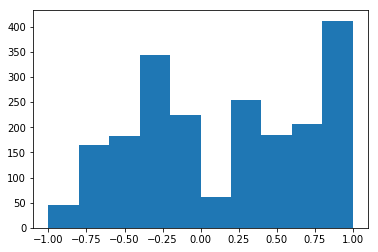

In [191]:
t=list(logsigma_5042_dict.values())
plt.hist(normscale(t,xmin=-10.5))

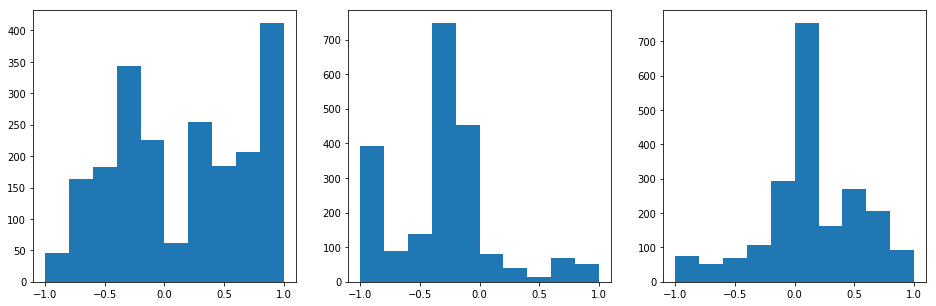

In [11]:
#rescale logsigma, logASR, E_a
logsigma_rescale = normscale(list(logsigma_5042_dict.values()),xmin=-10.5)
logASR_rescale = normscale(list(logasr_5046_dict.values()),normrange=(1,-1)) #reverse so that higher values are better
Ea_rescale = normscale(list(dryEa_5227_dict.values()),xmax=1,normrange=(1,-1)) #reverse so that higher values are better

fig, axes = plt.subplots(1,3,figsize=(16,5))
for i,d in enumerate([logsigma_rescale,logASR_rescale,Ea_rescale]):
    ax = axes[i]
    ax.hist(d)

(array([ 62.,  44., 265., 197., 581., 429., 297., 146.,  30.,  28.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

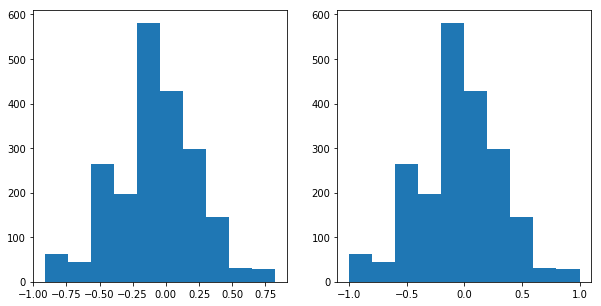

In [12]:
#create wtd average of rescaled values
sigma_wt = 0.1
asr_wt = 0.5
Ea_wt = 0.4

combo_value = logsigma_rescale*sigma_wt + logASR_rescale*asr_wt + Ea_rescale*Ea_wt
norm_value = normscale(combo_value)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(combo_value)
axes[1].hist(norm_value)

In [13]:
#make lookup dict for combined normalized value
normval_dict = dict(zip(calc_inp_Co23Fe34.keys(),norm_value))

In [14]:
def normval_slice_plots(slice_axis,tern_axes,slice_vals,zdict,zfunc,title,
                         vmin=None,vmax=None,cmap = plt.cm.viridis):
    fig, axes = plt.subplots(1,3,figsize=(20,6))
    if vmin is None:
        if zfunc == log_dict_lookup:
            vmin = np.log10(min(zdict.values()))
        else:
            vmin = min(zdict.values())
    if vmax is None:
        if zfunc == log_dict_lookup:
            vmax= np.log10(max(zdict.values()))
        else:
            vmax = max(zdict.values())
            
    print(vmin,vmax)

    for i,slice_val in enumerate(slice_vals):
        ax = axes[i]
        tax, vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, slice_axis=slice_axis,
                                         tern_axes=tern_axes, vmin=vmin, vmax=vmax, ax=ax, Ba=0.9,
                                         zfunc_kwargs={'kdict':zdict}, cmap = cmap,
                                         labelsize=15, multiple=(1-slice_val)/5, add_labeloffset=0.05,
                                         tick_kwargs={'tick_formats': '%.2g', 'offset': 0.03,'fontsize':11} )


        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.15,y=0.9,size=15,bbox=props)

    add_colorbar(vmin=vmin,vmax=vmax,label='Normalized Value',labelkwargs={'size':16,'labelpad':10}, cmap=cmap,
                 tickparams={'labelsize':12}, tickformat='%.1f',cbrect=[0.9,0.18,0.02,0.53],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
    fig.suptitle(title,size='18')
    fig.subplots_adjust(top=0.7)
    
    return fig, axes

-1 1


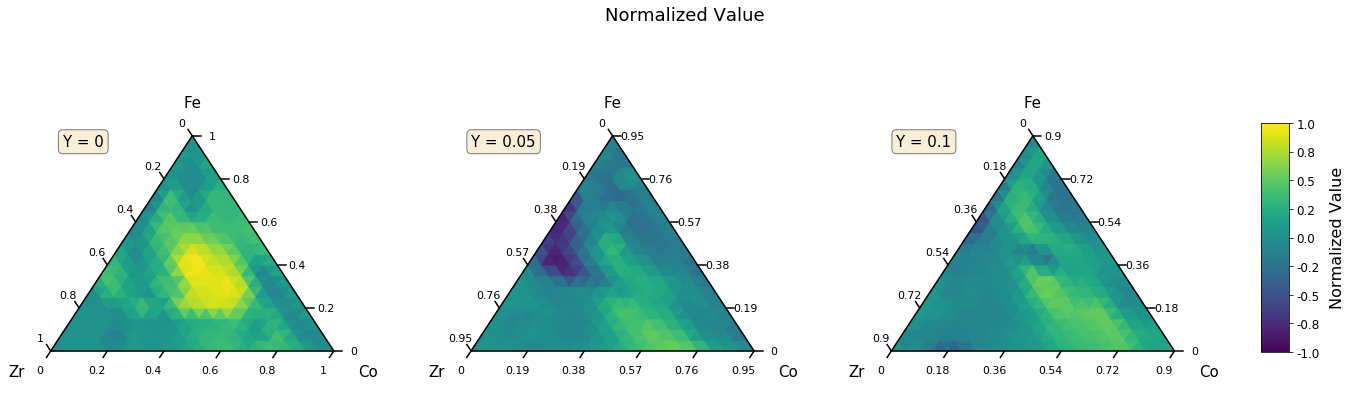

In [20]:
fig, axes = normval_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.05,0.1],
                                   zdict=normval_dict,zfunc=dict_lookup, vmin=-1, vmax=1,
                                   title='Normalized Value')
plt.savefig(os.path.join(plotdir,'pred_combovalue_sliceY_low.png'),dpi=500)

In [35]:
def pred_sigma_slice_plots(slice_axis,tern_axes,slice_vals,zdict,zfunc,title,logscale=False,vmin=None,vmax=None,cmap=plt.cm.viridis):
    fig, axes = plt.subplots(1,3,figsize=(20,6))
    if vmin is None:
        if zfunc == log_st_lookup:
            vmin = np.log10(min(zdict.values()))
        else:
            vmin = min(zdict.values())
    if vmax is None:
        if zfunc == log_st_lookup:
            vmax= np.log10(max(zdict.values()))
        else:
            vmax = max(zdict.values())
            
    print(vmin,vmax)

    for i,slice_val in enumerate(slice_vals):
        ax = axes[i]
        tax, vmin, vmax = quat_slice_heatmap2(tuple_scale=20,zfunc=zfunc,slice_val=slice_val, slice_axis=slice_axis,
                                         tern_axes=tern_axes, vmin=vmin, vmax=vmax, ax=ax, Ba=0.9,
                                         zfunc_kwargs={'kdict':zdict},cmap=cmap,
                                         labelsize=15, multiple=(1-slice_val)/5, add_labeloffset=0.05,
                                         tick_kwargs={'tick_formats': '%.2g', 'offset': 0.03,'fontsize':11} )


        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.set_title('{} = {:.2g}'.format(slice_axis,slice_val),x=0.15,y=0.9,size=15,bbox=props)

    if logscale==True:
        cblabel = 'Predicted log($\sigma_{elec}$)'
        cbtickfmt = '%.1f'
    else:
        cblabel = 'Predicted $\sigma_{elec}$'
        cbtickfmt = '%.0e'
    add_colorbar(vmin=vmin,vmax=vmax,label=cblabel,labelkwargs={'size':16,'labelpad':10},
                 tickparams={'labelsize':12}, tickformat=cbtickfmt,cbrect=[0.9,0.18,0.02,0.53],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
    
    fig.suptitle(title,size='18')
    fig.subplots_adjust(top=0.7)
    
    return fig, axes

-10.5 -4


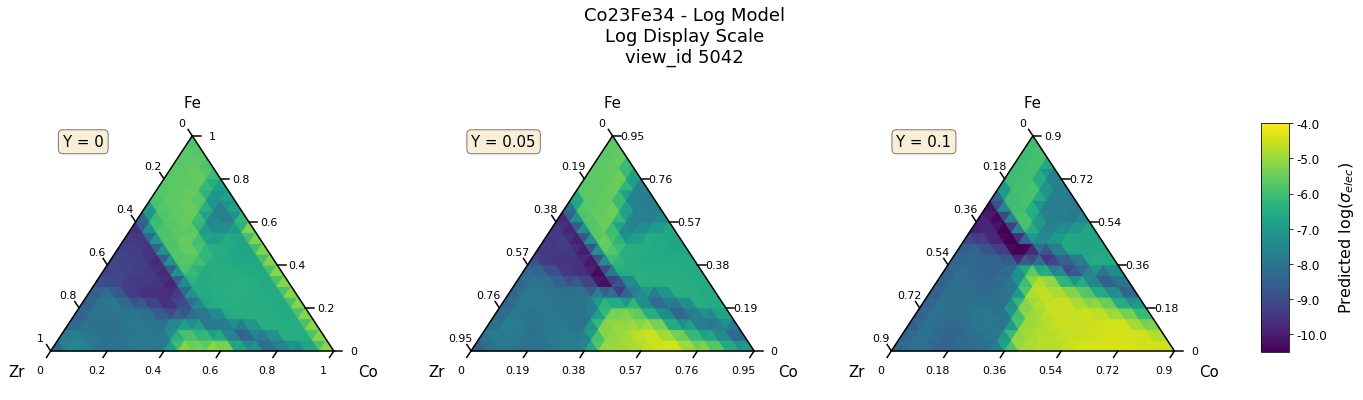

In [38]:
fig, axes = pred_sigma_slice_plots(slice_axis='Y',tern_axes=['Co','Fe','Zr'],slice_vals=[0,0.05,0.1],
                                   zdict=logsigma_5042_dict,zfunc=dict_lookup, vmin = -10.5, vmax=-4,
                                   title='Co23Fe34 - Log Model\nLog Display Scale\nview_id 5042',
                                   logscale=True)
plt.savefig(os.path.join(tcodir,'scripts/conductivity/plots/pred_logsigma5042_sliceY_low.png'),dpi=500)